<a href="https://colab.research.google.com/github/Ollie-Maher/PyTorch-projects/blob/main/Basic_Modelling_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Basics
This project will walk through the basics principles of PyTorch using their examples and datasets available with the package.
Additionally, I will implement a novel layer which learns the activation relationship between two other layers which should improve model performance.

First we shall import PyTorch and numpy

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

torch.__version__

'2.5.0+cu121'

Next we shall load the MNIST dataset and separate it into baches of 64

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Checking shape of input data.

In [ ]:
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Now we shall implement a simple 3 layer model using nn.module. It shall use 2 hidden ReLu layers and a softmax final layer.

In [ ]:
# Get device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class Model(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Model, self).__init__()
    self.flatten = nn.Flatten()
    self.ReLu_stack = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, num_classes),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.ReLu_stack(x)
    return logits


input_size = 784  # Input size for MNIST
hidden_size = 128
num_classes = 10
model = Model(input_size, hidden_size, num_classes).to(device)
print(model)

Using cuda device
Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (ReLu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)


Loss function implementation and optimizer.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Training loop, using batches of 64

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Test model performance and output accuracy and loss

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

# Training loop
Here we will train and test the performance of our model for 10 epochs.

In [ ]:
epochs = 10
stats = np.empty((epochs, 2))
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    stats[t,0], stats[t,1] = test(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302526  [   64/60000]
loss: 2.303222  [ 6464/60000]
loss: 2.302599  [12864/60000]
loss: 2.301057  [19264/60000]
loss: 2.302091  [25664/60000]
loss: 2.301293  [32064/60000]
loss: 2.300387  [38464/60000]
loss: 2.302081  [44864/60000]
loss: 2.302555  [51264/60000]
loss: 2.302075  [57664/60000]
Test Error: 
 Accuracy: 10.8%, Avg loss: 2.302207 

Epoch 2
-------------------------------
loss: 2.302702  [   64/60000]
loss: 2.303531  [ 6464/60000]
loss: 2.301990  [12864/60000]
loss: 2.302292  [19264/60000]
loss: 2.303318  [25664/60000]
loss: 2.302635  [32064/60000]
loss: 2.301850  [38464/60000]
loss: 2.304260  [44864/60000]
loss: 2.300471  [51264/60000]
loss: 2.302670  [57664/60000]
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.301897 

Epoch 3
-------------------------------
loss: 2.303113  [   64/60000]
loss: 2.302749  [ 6464/60000]
loss: 2.301765  [12864/60000]
loss: 2.302524  [19264/60000]
loss: 2.299942  [25664/60000]
loss: 2.301542  [32064/600

#Expanding the basic model
This model contains an additional hidden layer to match our new architecture.

In [ ]:
class FourLayerModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(FourLayerModel, self).__init__()
    self.flatten = nn.Flatten()
    self.ReLu_stack = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, num_classes),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.ReLu_stack(x)
    return logits


input_size = 784  # Input size for MNIST
hidden_size = 128
num_classes = 10
four_layer_model = FourLayerModel(input_size, hidden_size, num_classes).to(device)
print(four_layer_model)

FourLayerModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (ReLu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
    (7): Softmax(dim=1)
  )
)


This model contains as expanded hidden layer and output layer to match our new architecture.

In [ ]:
class ExpandedModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(ExpandedModel, self).__init__()
    self.flatten = nn.Flatten()
    self.ReLu_stack = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size * 2),
        nn.ReLU(),
        nn.Linear(hidden_size * 2, num_classes),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.ReLu_stack(x)
    return logits


input_size = 784  # Input size for MNIST
hidden_size = 128
num_classes = 10
expanded_model = ExpandedModel(input_size, hidden_size, num_classes).to(device)
print(expanded_model)

ExpandedModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (ReLu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)


#A New Architecture
In this section, I will implement a different achitecture for my neural network. This model will use a non-sequential layer achitecture where every 3rd layer will take the activation of both previous layers and learn their associations.

Now we shall run the training and testing loop

In [ ]:
class CausalModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CausalModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size * hidden_size, hidden_size)  # Outer product layer
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size * 2, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x1 = self.relu1(self.fc1(x))
        x2 = self.relu2(self.fc2(x1))
        outer_product = torch.einsum('bi,bj->bij', x1, x2)  # Outer product
        outer_product = outer_product.reshape(outer_product.shape[0], -1)  # Flatten
        x3 = self.relu3(self.fc3(outer_product))
        logits = self.softmax(self.fc4(torch.cat((x3,x2), dim=1)))
        return logits

input_size = 784  # Input size for MNIST
hidden_size = 128
num_classes = 10
causal_model = CausalModel(input_size, hidden_size, num_classes).to(device)
print(causal_model)

# Loss function and optimizer for the new model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(causal_model.parameters(), lr=1e-3)

# Training loop for the new model (you can reuse the train and test functions)
epochs = 10
stats_causal = np.empty((epochs, 2))
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, causal_model, loss_fn, optimizer)
    stats_causal[t,0], stats_causal[t,1] = test(test_loader, causal_model, loss_fn)
print("Done!")

CausalModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16384, out_features=128, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=256, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)
Epoch 1
-------------------------------
loss: 2.301939  [   64/60000]
loss: 2.303375  [ 6464/60000]
loss: 2.302644  [12864/60000]
loss: 2.303021  [19264/60000]
loss: 2.303459  [25664/60000]
loss: 2.303367  [32064/60000]
loss: 2.302814  [38464/60000]
loss: 2.303375  [44864/60000]
loss: 2.302586  [51264/60000]
loss: 2.303245  [57664/60000]
Test Error: 
 Accuracy: 9.8%, Avg loss: 2.302708 

Epoch 2
-------------------------------
loss: 2.301623  [   64/60000]
loss: 2.302452  [ 6464/60000]
loss: 2.302183  [12864/60000]
loss: 2.302252  [19264/60000]
loss: 2.303652  [25664/60000]
loss: 2.302172  [32064/6000

#Training all models
Running all the training loops.

In [ ]:
causal_model = CausalModel(input_size, hidden_size, num_classes).to(device)
optimizer = torch.optim.SGD(causal_model.parameters(), lr=1e-3)

stats_causal = np.empty((epochs, 2))
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, causal_model, loss_fn, optimizer)
    stats_causal[t,0], stats_causal[t,1] = test(test_loader, causal_model, loss_fn)
print("Done!")

four_layer_model = FourLayerModel(input_size, hidden_size, num_classes).to(device)
optimizer = torch.optim.SGD(four_layer_model.parameters(), lr=1e-3)

stats_four_layer = np.empty((epochs, 2))
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, four_layer_model, loss_fn, optimizer)
    stats_four_layer[t,0], stats_four_layer[t,1] = test(test_loader, four_layer_model, loss_fn)
print("Done!")

expanded_model = ExpandedModel(input_size, hidden_size, num_classes).to(device)
optimizer = torch.optim.SGD(expanded_model.parameters(), lr=1e-3)

stats_expanded = np.empty((epochs, 2))
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, expanded_model, loss_fn, optimizer)
    stats_expanded[t,0], stats_expanded[t,1] = test(test_loader, expanded_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302321  [   64/60000]
loss: 2.302750  [ 6464/60000]
loss: 2.303098  [12864/60000]
loss: 2.302280  [19264/60000]
loss: 2.303416  [25664/60000]
loss: 2.302011  [32064/60000]
loss: 2.302184  [38464/60000]
loss: 2.301965  [44864/60000]
loss: 2.302613  [51264/60000]
loss: 2.302727  [57664/60000]
Test Error: 
 Accuracy: 9.3%, Avg loss: 2.302402 

Epoch 2
-------------------------------
loss: 2.302490  [   64/60000]
loss: 2.302949  [ 6464/60000]
loss: 2.301963  [12864/60000]
loss: 2.302613  [19264/60000]
loss: 2.302400  [25664/60000]
loss: 2.303196  [32064/60000]
loss: 2.303847  [38464/60000]
loss: 2.301867  [44864/60000]
loss: 2.302364  [51264/60000]
loss: 2.302763  [57664/60000]
Test Error: 
 Accuracy: 10.6%, Avg loss: 2.302226 

Epoch 3
-------------------------------
loss: 2.301793  [   64/60000]
loss: 2.301368  [ 6464/60000]
loss: 2.301844  [12864/60000]
loss: 2.302128  [19264/60000]
loss: 2.302478  [25664/60000]
loss: 2.301429  [32064/6000

Graph results

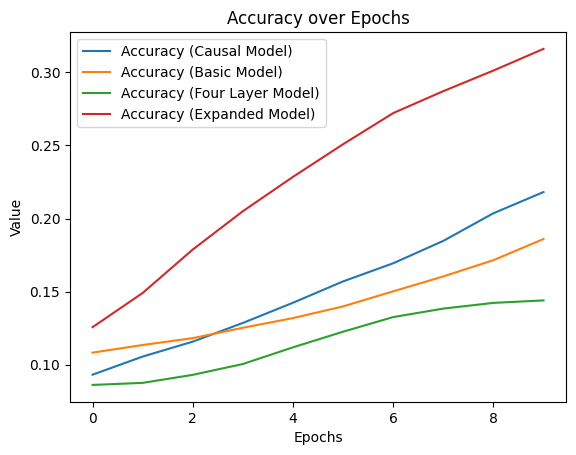

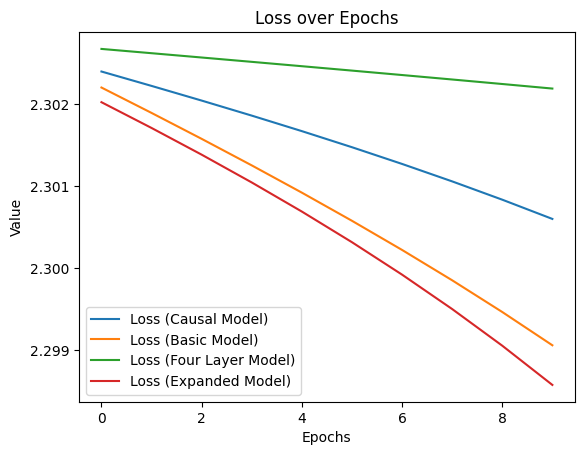

In [ ]:
# Plotting the performance of the new model
plt.plot(np.arange(epochs), stats_causal[:, 0], label='Accuracy (Causal Model)')
plt.plot(np.arange(epochs), stats[:, 0], label='Accuracy (Basic Model)')
plt.plot(np.arange(epochs), stats_four_layer[:, 0], label='Accuracy (Four Layer Model)')
plt.plot(np.arange(epochs), stats_expanded[:, 0], label='Accuracy (Expanded Model)')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()
plt.plot(np.arange(epochs), stats_causal[:, 1], label='Loss (Causal Model)')
plt.plot(np.arange(epochs), stats[:, 1], label='Loss (Basic Model)')
plt.plot(np.arange(epochs), stats_four_layer[:, 1], label='Loss (Four Layer Model)')
plt.plot(np.arange(epochs), stats_expanded[:, 1], label='Loss (Expanded Model)')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Loss over Epochs')
plt.legend()
plt.show()


Check learning rate

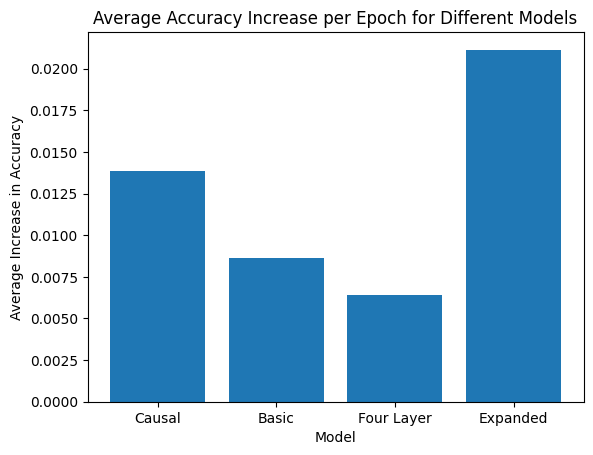

In [ ]:
# Calculate average increase in accuracy for each model
avg_increase_causal = np.mean(np.diff(stats_causal[:, 0]))
avg_increase_basic = np.mean(np.diff(stats[:, 0]))
avg_increase_four_layer = np.mean(np.diff(stats_four_layer[:, 0]))
avg_increase_expanded = np.mean(np.diff(stats_expanded[:, 0]))

# Create a bar plot
model_names = ['Causal', 'Basic', 'Four Layer', 'Expanded']
avg_increases = [avg_increase_causal, avg_increase_basic, avg_increase_four_layer, avg_increase_expanded]

plt.bar(model_names, avg_increases)
plt.xlabel('Model')
plt.ylabel('Average Increase in Accuracy')
plt.title('Average Accuracy Increase per Epoch for Different Models')
plt.show()

#Continued training


In [ ]:
def train_and_test_model(model, train_loader, test_loader, loss_fn, optimizer, epochs):

  start_time = time.time()
  for t in range(epochs):
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)

  end_time = time.time()
  training_time = end_time - start_time

  # Approximate FLOPs calculation
  flops = 0
  for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
      flops += module.in_features * module.out_features * 2  # Multiply and add for each connection

  return training_time, flops

epochs = 10  # Number of training epochs

# Measure time and FLOPs for each model
training_time_basic, flops_basic = train_and_test_model(model, train_loader, test_loader, loss_fn, optimizer, epochs)
training_time_four_layer, flops_four_layer = train_and_test_model(four_layer_model, train_loader, test_loader, loss_fn, optimizer, epochs)
training_time_expanded, flops_expanded = train_and_test_model(expanded_model, train_loader, test_loader, loss_fn, optimizer, epochs)
training_time_causal, flops_causal = train_and_test_model(causal_model, train_loader, test_loader, loss_fn, optimizer, epochs)


# Print results
print("Basic Model: Training time:", training_time_basic, "seconds, FLOPs (approx.):", flops_basic)
print("Four Layer Model: Training time:", training_time_four_layer, "seconds, FLOPs (approx.):", flops_four_layer)
print("Expanded Model: Training time:", training_time_expanded, "seconds, FLOPs (approx.):", flops_expanded)
print("Causal Model: Training time:", training_time_causal, "seconds, FLOPs (approx.):", flops_causal)
